# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

!pip install sparse
!pip install wordcloud
!pip install tensorflow_hub
!pip install catboost 

In [46]:
# общие библиотеки Pandas
#from IPython.display import clear_output
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import string

import requests
import zipfile
import io
from urllib.request import urlopen
import shutil


from catboost import CatBoostRegressor, Pool
#from catboost.utils import get_confusion_matrix

import torch
import torch.nn as nn
import sparse
#from sparse import SparseTensor

from sklearn.metrics import f1_score ,root_mean_squared_error,r2_score,median_absolute_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder
from sklearn.model_selection import (train_test_split,GridSearchCV,cross_val_score)
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge, PassiveAggressiveRegressor,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from wordcloud import WordCloud


#m = Mystem() 

import spacy
from spacy.lang.en import English
from scipy.sparse import hstack,coo_array, vstack,csr_matrix,coo_matrix
#spacy.load('en_core_web_sm')
!python -m spacy download en_core_web_sm
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords as nltk_sw
#from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist


import gensim
from gensim.models import Word2Vec,Doc2Vec
from gensim.utils import simple_preprocess
import gensim.downloader as api

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image


from tqdm import notebook
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
from PIL import Image

import warnings
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')
import sys
import os

#random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
#torch.use_deterministic_algorithms(True)

from numba import jit, cuda, njit 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
jit(target_backend='cuda') 
njit(parallel=True)



if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')
    
#optuna.logging.set_verbosity(optuna.logging.WARNING)
    
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:,.3f}'.format
pd.DataFrame.iteritems = pd.DataFrame.items
RANDOM_STATE = 255
TEST_SIZE = 0.20
vector_size=800
warnings.filterwarnings('ignore')

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 5.7 MB/s eta 0:00:03
     ---------------- ----------------------- 5.2/12.8 MB 18.8 MB/s eta 0:00:01
     ----------------------- ---------------- 7.6/12.8 MB 15.7 MB/s eta 0:00:01
     --------------------------------- ----- 11.0/12.8 MB 15.3 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 15.4 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Using device: cuda


Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'
Invalid -W option ignored: unknown warning category: 'ConvergenceWarning'

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from numba import jit, cuda, njit 
import tensorflow as tf
import transformers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
jit(target_backend='cuda') 
njit(parallel=True)

import multiprocessing
cores = multiprocessing.cpu_count()
print(f"Number of CPU cores: {cores}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
#print('device  :',device)

Using device: cuda
Number of CPU cores: 4
Using device: cuda


In [3]:
# лемманизация 

def lem_spa(text):
    jit(target_backend='cuda') 
    njit(parallel=True)
    physical_devices = tf.config.list_physical_devices('GPU') 
    #dis_word = ['girl','girls','boy','boys','children','child','baby']
    text_lem = " ".join([token.lemma_ for token in nlp(text)
                         if (token.is_alpha
                             and not token.is_currency
                             and not token.is_digit
                             #and not token.is_oov
                             and not token.is_space
                             and not token.is_stop
                             and not token.like_num
                             and not token.is_punct 
                             and not token.lemma_ in stopwords
                             and not token.pos_ == "PROPN"
                             and not len(token.lemma_)<=1 )
                        ])       
       
    return (text_lem)

In [4]:
# фукция параметров кросвалидации моделей
def cv_model(clf,X_train,y_train,X_test,vec):
        
    physical_devices = tf.config.list_physical_devices('GPU')  
    param_grid = {}
    if clf.__class__.__name__ == 'SVR' :
        param_grid = {#'models__tol': np.arange(0.001, 0.01, 0.006),
                     'models__C':np.arange(0.1, 1.2, 0.4) }
        
    elif clf.__class__.__name__ == 'Ridge' :
        param_grid = {'models__alpha': np.arange(0.3, 1, 0.1)                     }
    elif clf.__class__.__name__ == 'LinearRegression' :
        X_train = X_train.toarray()
        X_test = X_test.toarray()
        #scaler = StandardScaler()
        #X_train = scaler.fit_transform(X_train)
        #X_test = scaler.transform(X_test)
    else  : param_grid = {} 
    #display (X_train,X_test)
    pipe_final = Pipeline([('models',clf)])
    GridCV = GridSearchCV(
        pipe_final,
        param_grid=param_grid, 
        cv=3,
        scoring='neg_mean_absolute_error',
        error_score='raise',
        verbose=False,
        n_jobs=-1
    )
    GridCV.fit(X_train, y_train)
    clf_descr = clf.__class__.__name__
        
    print
    print(clf_descr)
 
        
    pred = GridCV.best_estimator_.predict(X_train)
    score = mean_absolute_error(y_train, pred)  #f1_score(y_test, pred) GridCV.best_score_
    
    print(f"best parames :   {GridCV.best_params_}")
    print(f"best score :   {score}") #GridCV.best_score_
    return (clf_descr, score,vec)

In [5]:
# кросвалидация моделей

def cross_m (X_tr,y_train,X_ts,vec):
    physical_devices = tf.config.list_physical_devices('GPU')
    results = []
    for clf in (
        
        #(LogisticRegression(C=0.01, max_iter=500)),
        (Ridge(max_iter=300,random_state=RANDOM_STATE)),#,solver="sparse_cg")),
        (KNeighborsRegressor(n_neighbors=80)),
        (LinearRegression(n_jobs=-1)),
        (RandomForestRegressor(warm_start=True,random_state=RANDOM_STATE)),
        (SVR(max_iter=300)), #,cache_size=8000,gamma='auto',probability=True,
        (SGDRegressor( alpha=1e-4, n_iter_no_change=3, early_stopping=True)),
        (PassiveAggressiveRegressor()),
     
        (CatBoostRegressor(iterations=1000, learning_rate=0.001, depth=6,                           
                            loss_function='MAE',
                            random_seed = RANDOM_STATE,
                            early_stopping_rounds = 400,
                            allow_writing_files=False,
                            verbose= False))
    ):
        print("=" * 80)
        
        #model_name,m_score = (cv_model(clf,X_tr,X_ts))
        results.append(cv_model(clf,X_tr,y_train,X_ts,vec) )
    return results

## Загрузка данных


    - df1 - train_dataset.csv
    - df2 - CrowdAnnotations.tsv
    - df3 - ExpertAnnotations.tsv
    - df4 - test_queries.csv
    

In [6]:
# чтение фаила
import zipfile
try :
    df1 = pd.read_csv('D:/YandexDisk/masterskay/сводный проект 5/to_upload/train_dataset.csv')#,
    path_train = '/to_upload/train/'
    zipfile = 0                  
except:
    url = 'https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip'
    file_name = 'dsplus_integrated_project_4.zip'
    
    with urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        
    # extracting required file from zipfile
        with zipfile.ZipFile(file_name) as zf:
            zf.extract('to_upload/train_dataset.csv')

    df1 = pd.read_csv('to_upload/train_dataset.csv')
    zipfile = 1
                      
df1['query_text'] = df1['query_text'].apply(lambda x: x.lower())
display(df1.head(10))
df1.info()
df1.nunique()



,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...
9,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,a young child is wearing blue goggles and sitt...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


image         1000
query_id       977
query_text     977
dtype: int64

In [7]:
# информация взята с сайтов
# https://lewisforemanschool.ru/popularwords/children 
# https://letslearnslang.com/slang-words-for-baby/

dis_word = ['girl','girls','boy','boys','children','child','baby',
            'kid','kids','babies','infant','toddler','newborn','adolescent',
            'teenager','junior','kiddie','kiddo','munchkin','squirt','tike','tyke',
            'tot']
chk_pat = '(?:{})'.format('|'.join(dis_word))

# отчищаем базу от 
df1_clear = df1.copy()
df1_clear['disclaim'] = df1_clear['query_text'].apply(lambda x  : bool(re.search(chk_pat, x)))#, flags=re.I

df_fdc = df1_clear['image'][df1_clear['disclaim']==True]
df_fdc = df_fdc.drop_duplicates().copy()

df1_clear = df1_clear[~df1_clear['image'].isin(df_fdc)].copy()
df1_clear.info()
display(df1_clear.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1400 entries, 25 to 5818
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       1400 non-null   object
 1   query_id    1400 non-null   object
 2   query_text  1400 non-null   object
 3   disclaim    1400 non-null   bool  
dtypes: bool(1), object(3)
memory usage: 45.1+ KB


,image,query_id,query_text,disclaim
25,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .,False
29,3251976937_20625dc2b8.jpg,3207358897_bfa61fa3c6.jpg#2,a woman plays with long red ribbons in an empt...,False
32,1962729184_6996e128e7.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,False
35,3100251515_c68027cc22.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,False
36,370614351_98b8a166b9.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,False


In [8]:
try :
    df2 = pd.read_csv('D:/YandexDisk/masterskay/сводный проект 5/to_upload/CrowdAnnotations.tsv' , sep ='\t',
                      names = ['image','query_id', 'part_t','col_t','col_f'])
    zipfile = 0                  
except:
   
    url = 'https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip'
    file_name = 'dsplus_integrated_project_4.zip'
    
    with urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        
    # extracting required file from zipfile
        with zipfile.ZipFile(file_name) as zf:
            zf.extract('to_upload/CrowdAnnotations.tsv')

    df2 = pd.read_csv('to_upload/CrowdAnnotations.tsv', sep ='\t',
                      names = ['image','query_id', 'part_t','col_t','col_f'])
    zipfile = 1

display(df2.head())

df2.info()
df2.nunique()


,image,query_id,part_t,col_t,col_f
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000,0,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image     47830 non-null  object 
 1   query_id  47830 non-null  object 
 2   part_t    47830 non-null  float64
 3   col_t     47830 non-null  int64  
 4   col_f     47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


image       1000
query_id    1000
part_t        12
col_t          6
col_f          7
dtype: int64

In [9]:
try :
    df3 = pd.read_csv('D:/YandexDisk/masterskay/сводный проект 5/to_upload/ExpertAnnotations.tsv' , sep ='\t',
                      names = ['image','query_id', 'ex_1','ex_2','ex_3',])
    zipfile = 0                 
except:
    url = 'https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip'
    file_name = 'dsplus_integrated_project_4.zip'
    
    with urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        
    # extracting required file from zipfile
        with zipfile.ZipFile(file_name) as zf:
            zf.extract('to_upload/ExpertAnnotations.tsv')

    df3 = pd.read_csv('to_upload/ExpertAnnotations.tsv', sep ='\t',
                      names = ['image','query_id', 'ex_1','ex_2','ex_3',])
    zipfile = 1
display(df3.head())
df3.info()
df3.nunique()

,image,query_id,ex_1,ex_2,ex_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   ex_1      5822 non-null   int64 
 3   ex_2      5822 non-null   int64 
 4   ex_3      5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


image       1000
query_id     977
ex_1           4
ex_2           4
ex_3           4
dtype: int64

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [10]:
#display(sorted(df1['image'].unique()))
#display(sorted(df3['image'].unique()))

display(sorted(df1['image'].unique())==sorted(df3['image'].unique()))
display(sorted(df1['image'].unique())==sorted(df2['image'].unique()))
display(sorted(df3['query_id'].unique())==sorted(df2['query_id'].unique()))
display(sorted(df1['query_id'].unique())==sorted(df2['query_id'].unique()))
display(sorted(df1['query_id'].unique())==sorted(df3['query_id'].unique()))
#display(sorted(list(set(sorted(df2['query_id'].unique()))-set((sorted(df1['query_id'].unique()))))))
#display(sorted(list(set(sorted(df2['query_id'].unique()))-set((sorted(df3['query_id'].unique()))))))


True

True

False

False

True

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [11]:
q_ex = sorted(list(set(sorted(df2['query_id'].unique()))-set((sorted(df1['query_id'].unique())))))
display(df2[df2['query_id'].isin(q_ex)])

,image,query_id,part_t,col_t,col_f
35,1056338697_4f7d7ce270.jpg,3499720588_c32590108e.jpg#2,0.000,0,3
143,1084040636_97d9633581.jpg,2479162876_a5ce3306af.jpg#2,0.000,0,3
156,1084040636_97d9633581.jpg,3019842612_8501c1791e.jpg#2,0.000,0,3
197,1096395242_fc69f0ae5a.jpg,2431832075_00aa1a4457.jpg#2,0.000,0,3
245,1107246521_d16a476380.jpg,2431832075_00aa1a4457.jpg#2,0.000,0,3
...,...,...,...,...,...
47504,917574521_74fab68514.jpg,2431832075_00aa1a4457.jpg#2,0.000,0,3
47538,925491651_57df3a5b36.jpg,2054869561_ff723e9eab.jpg#2,0.000,0,3
47552,925491651_57df3a5b36.jpg,2482629385_f370b290d1.jpg#2,0.000,0,3
47595,929679367_ff8c7df2ee.jpg,2194494220_bb2178832c.jpg#2,0.000,0,3


In [12]:
df2=[]
df_final = df1_clear.merge(df3, how='left', on=['query_id','image'], validate='one_to_one')#,'query_id']) , validate='one_to_one'
df_final = df_final.drop_duplicates().copy()
df_final.info()
display(df_final.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       1400 non-null   object
 1   query_id    1400 non-null   object
 2   query_text  1400 non-null   object
 3   disclaim    1400 non-null   bool  
 4   ex_1        1400 non-null   int64 
 5   ex_2        1400 non-null   int64 
 6   ex_3        1400 non-null   int64 
dtypes: bool(1), int64(3), object(3)
memory usage: 67.1+ KB


,image,query_id,query_text,disclaim,ex_1,ex_2,ex_3
0,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .,False,1,2,2
1,3251976937_20625dc2b8.jpg,3207358897_bfa61fa3c6.jpg#2,a woman plays with long red ribbons in an empt...,False,1,1,1
2,1962729184_6996e128e7.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,False,1,2,3
3,3100251515_c68027cc22.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,False,1,1,1
4,370614351_98b8a166b9.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,False,1,1,1


In [13]:
df_final['ex_max'] = round(df_final[['ex_1','ex_2','ex_3']].mean(axis=1)/4,2)
df_final['ex_min'] = df_final[['ex_1','ex_2','ex_3']].min(axis=1)
df_final['deff'] = df_final['ex_max'] -  df_final['ex_min']
display(df_final[df_final['deff']>=3])
display(df_final.head())



,image,query_id,query_text,disclaim,ex_1,ex_2,ex_3,ex_max,ex_min,deff


,image,query_id,query_text,disclaim,ex_1,ex_2,ex_3,ex_max,ex_min,deff
0,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .,False,1,2,2,0.420,1,-0.580
1,3251976937_20625dc2b8.jpg,3207358897_bfa61fa3c6.jpg#2,a woman plays with long red ribbons in an empt...,False,1,1,1,0.250,1,-0.750
2,1962729184_6996e128e7.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,False,1,2,3,0.500,1,-0.500
3,3100251515_c68027cc22.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,False,1,1,1,0.250,1,-0.750
4,370614351_98b8a166b9.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,False,1,1,1,0.250,1,-0.750


In [14]:
jit(target_backend = 'cuda') 
njit(parallel=True)
nlp = spacy.load ('en_core_web_sm')
stop_word_add_spa = {'www','jpg','hi','utc','etc','yum'}
nlp.Defaults.stop_words |= stop_word_add_spa
stopwords = nlp.Defaults.stop_words #|= stop_word_add_spa # nltk.corpus.stopwords.words('english')

df_final['tag'] = df_final['ex_max']#.apply(lambda x: 1 if x>=3 else 0)
df_final = df_final.drop(['ex_1','ex_2','ex_3','ex_max','ex_min','deff','disclaim'],axis=1).copy()
df_final['lemm_text'] =  df_final['query_text'].apply(lambda x: lem_spa(x))
display(df_final.head())
display(df_final.nunique())

,image,query_id,query_text,tag,lemm_text
0,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,a man sleeps under a blanket on a city street .,0.420,man sleep blanket city street
1,3251976937_20625dc2b8.jpg,3207358897_bfa61fa3c6.jpg#2,a woman plays with long red ribbons in an empt...,0.250,woman play long red ribbon square
2,1962729184_6996e128e7.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,0.500,chinese market street winter time
3,3100251515_c68027cc22.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,0.250,chinese market street winter time
4,370614351_98b8a166b9.jpg,3286822339_5535af6b93.jpg#2,chinese market street in the winter time .,0.250,chinese market street winter time


image         269
query_id      548
query_text    548
tag            10
lemm_text     548
dtype: int64

tag
0.250    455
0.500    191
0.330    184
0.420    160
0.750    104
0.580     98
1.000     92
0.670     65
0.830     26
0.920     25
Name: count, dtype: int64

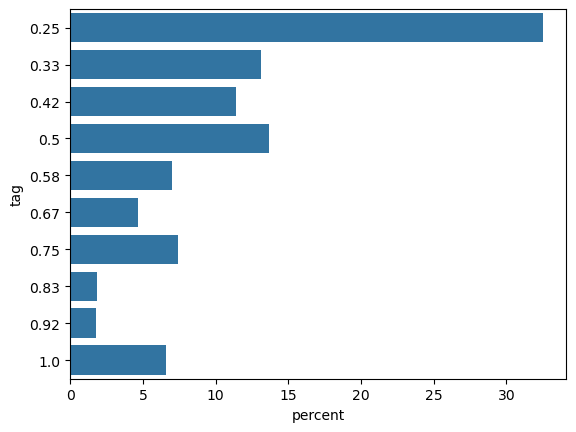

In [15]:
display(df_final['tag'].value_counts())
sns.countplot(y='tag',data=df_final,stat='percent')
plt.show()         

[('dog', 554),
 ('man', 320),
 ('white', 229),
 ('run', 188),
 ('black', 177),
 ('woman', 129),
 ('jump', 115),
 ('people', 108),
 ('stand', 105),
 ('water', 100),
 ('brown', 97),
 ('snow', 91),
 ('walk', 83),
 ('wear', 82),
 ('red', 81)]

<Axes: xlabel='Samples', ylabel='Counts'>

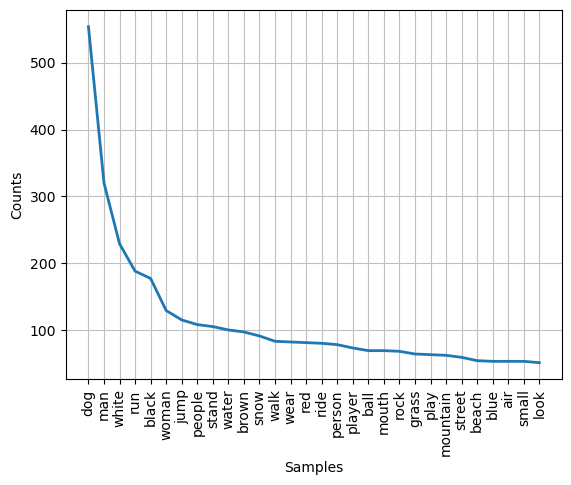

In [16]:
#df_final['tokezied_text'] = df_final['lemm_text'].apply(lambda x: simple_preprocess(x))
dd_t = df_final['lemm_text'].apply(lambda x: simple_preprocess(x))
#df_final['tokezied_text'][df_final['tag']==1]

jit(target_backend='cuda') 
njit(parallel=True)
de_t=dd_t.sum() 

fdist = FreqDist(de_t)
display(fdist.most_common(15))
fdist.plot(30,cumulative=False)

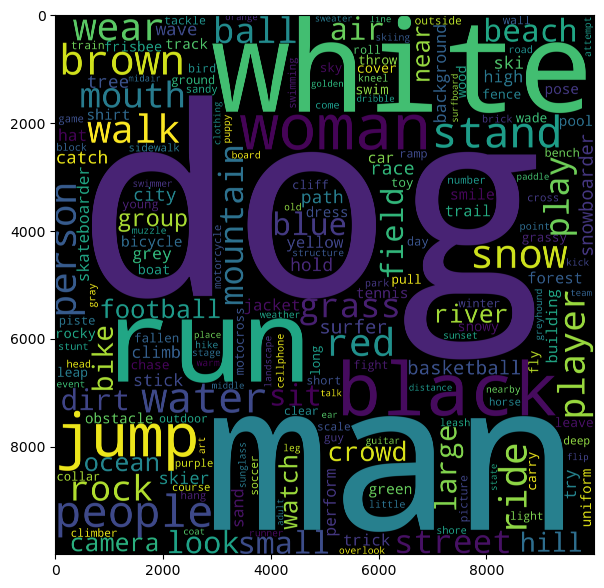

In [17]:
from wordcloud import WordCloud
#import matplotlib.font_manager as fm 
#font_list=fm.findSystemFonts() for font in font_list: print(font)

%matplotlib inline
jit(target_backend='cuda') 
njit(parallel=True)

text_raw = " ".join(de_t)
wordCloud = WordCloud(width = 10000,
                      height = 10000,
                      random_state=1,
                      background_color='black',
                      #colormap='Set2',
                      collocations=False).generate(text_raw)

plt.figure(figsize=(7,7))
plt.imshow(wordCloud)
plt.show()

### Выводы анализа данных и проверки
в ходе предподготовки данных было выявленно следующее:
 - после "отчистки" данных от stop слов , связанных с детьми - осталось 1400 записей.
 - в фаилах оценки от крауда присутствуют query_id (23 элемента) для которых нет текстового описания в фаиле Train
 - пары "query_id" и "image" в фаиле от крауда не совпадают ни с экспертными данными, ни с фаилом train / Скорее всего это системная ошибка : либо при постановке задачи, либо при при записи результата. Даные не являются полными, поэтому данными из этого фаила решено не использовать
 - при разметке целевой переменной принято решение, что оценку принять средней и нормализировать относительно максимума (4)
 - на оставшихся картинках среди "правильно размеченных" больше всего "белых мужчин с собакой бугущих к черной женщине, а люди прыгают, стоя в воде, и идет коричневый снег.." :)- наиболее чаще всего встречающиеся слова в описании 
 - для уменьшения вычислительной нагрузки принято решение векторизировать уникальные значения после лемманизации


## Разделение на train и test

In [18]:
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=df_final.drop(columns=['tag','image','query_id','query_text']), 
                                             y=df_final['tag'], groups=df_final['image']))
train_df, test_df = df_final.loc[train_indices], df_final.loc[test_indices]


In [19]:
y_train = train_df['tag']
y_test = test_df['tag']
X_train = train_df.drop(['tag','query_id','query_text'],axis=1) #'tokezied_text',
X_test = test_df.drop(['tag','query_id','query_text'],axis=1)

X_train.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 979 entries, 0 to 1399
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      979 non-null    object
 1   lemm_text  979 non-null    object
dtypes: object(2)
memory usage: 22.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 421 entries, 4 to 1397
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      421 non-null    object
 1   lemm_text  421 non-null    object
dtypes: object(2)
memory usage: 9.9+ KB


In [20]:
y_train = train_df['tag']
y_test = test_df['tag']

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

<div class="alert alert-info"> <b>Комментарии студентаV1:</b> Н. ..</div>

In [21]:
model50 = tf.keras.applications.resnet50.ResNet50(pooling='avg')
def classify(img_path):

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    
    prediction = model50.predict(img_preprocessed,verbose=0)
    

    #print(decode_predictions(prediction, top=3)[0])
    return(prediction.flatten())


In [22]:
def vec_img2(X_df,path,zp):
    df_im = pd.DataFrame()
    count = 0
    
    for im in X_df :
        jit(target_backend='cuda') 
        njit(parallel = True)
        if zp == 1 : 
            with urlopen(url) as response, open(file_name, 'wb') as out_file:
                shutil.copyfileobj(response, out_file)
                
             # extracting required file from zipfile
            with zipfile.ZipFile(file_name) as zf:
                zf.extract(path+im)
                
        #img = Image.open(path_train+im).convert('RGB')
        df_im[count] = [im,classify(path+im)] 
        count+=1
                
    df_im1 = df_im.T.copy()
    df_im1 = df_im1.rename(columns={0:'image',1:'img_vec'})
    df_im_s = coo_matrix(np.array ( [x for x in df_im1['img_vec']]))
    return (df_im_s)

In [23]:
path_train = 'to_upload/train_images/'
X_train_c_img = vec_img2(X_train['image'],path_train,zipfile)
X_test_c_img = vec_img2(X_test['image'],path_train,zipfile )


In [24]:
display(X_train_c_img , X_test_c_img)

<COOrdinate sparse matrix of dtype 'float32'
	with 979000 stored elements and shape (979, 1000)>

<COOrdinate sparse matrix of dtype 'float32'
	with 421000 stored elements and shape (421, 1000)>

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


### Векторизация Wordto vec

In [25]:
vector_size = 1000
#векторихация WordToVec 
physical_devices = tf.config.list_physical_devices('GPU')
jit(target_backend='cuda') 
njit(parallel=True)

# немного "обманем" модель 
sentences = [sentence.split() for sentence in df_final['lemm_text']] #X_train['lemm_text']]
w2v_model = Word2Vec(sentences, vector_size=vector_size, window=3, min_count=6, workers=cores-1)# 

#Building the Vocabulary Table
w2v_model.build_vocab(sentences)

#train mpdel W2w
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(vector_size)
    words_vecs = np.array(words_vecs)#
    return words_vecs.mean(axis=0)
    
def word_coo_add (X_c):
    X_w_s = coo_matrix(np.array ([(vectorize(sentence)) for sentence in X_c['lemm_text']]))
    return X_w_s



In [26]:
X_train_ww_s = word_coo_add(X_train).copy()
X_test_ww_s = word_coo_add(X_test).copy()

In [27]:
display(X_train_ww_s ,X_test_ww_s)

<COOrdinate sparse matrix of dtype 'float64'
	with 975000 stored elements and shape (979, 1000)>

<COOrdinate sparse matrix of dtype 'float64'
	with 420000 stored elements and shape (421, 1000)>

### векторизация TfidfVectorizer

In [28]:
jit(target_backend='cuda') 
njit(parallel = True)
physical_devices = tf.config.list_physical_devices('GPU')
count_tf_idf = TfidfVectorizer(ngram_range=(1, 5),max_features=vector_size,stop_words= 'english') #ngram_range=(2, 2),
tf_idf_X_train = count_tf_idf.fit_transform(X_train['lemm_text'])
tf_idf_X_test = count_tf_idf.transform(X_test['lemm_text'])


In [29]:
display(tf_idf_X_train,tf_idf_X_test) 

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8899 stored elements and shape (979, 1000)>

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3019 stored elements and shape (421, 1000)>

### векторизация с помощью модели BERT

In [35]:
jit(target_backend='cuda') 
njit(parallel = True)
max_len = vector_size
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel, #transformers.DistilBertModel,AutoTokenizer,AutoModel
                                                    transformers.DistilBertTokenizer, 'distilbert-base-uncased') #transformers.DistilBertTokenizer google-bert/bert-large-uncased

## Хотите BERT вместо distilBERT? Раскомментируйте следующую строку:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Загрузка предобученной модели/токенизатора 
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model_bert = model_class.from_pretrained(pretrained_weights)

#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',vocab_file='vocab.txt')#transformers.BertTokenizer()
tokenized_train = X_train['lemm_text'].apply(lambda x: tokenizer.encode(x,truncation=True,padding=True,
                                                                        max_length=max_len,
                                                                        add_special_tokens=True,))
                                                                        #return_tensors='tf' ))
tokenized_test = X_test['lemm_text'].apply(lambda x: tokenizer.encode(x,truncation=True,padding=True,
                                                                      max_length=max_len,
                                                                      add_special_tokens=True,))
                                                                      #return_tensors='tf' ))

In [36]:
# создаем векторы одинаковой длинны и массив mask

#jit(target_backend='cuda') 
njit(parallel=True)
def pad_att (tokenized):
    physical_devices = tf.config.list_physical_devices('GPU')
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    return (padded,attention_mask)    

padded_train,attention_mask_train  = pad_att(tokenized_train)
padded_test,attention_mask_test  = pad_att(tokenized_test)

In [37]:
display(len(padded_train),len(attention_mask_train))
display(len(padded_train[1]))
display(padded_train.shape[0])


979

979

19

979

In [38]:
#содание финальных эмбендингов

def bat_x (padded,attention_mask):
    physical_devices = tf.config.list_physical_devices('GPU')
    #model_bert.to(device)
    #token_ids = torch.tensor(padded_train).to(device)
    #attentionMask = torch.tensor(attention_mask_train).to(device)    
    jit(target_backend='cuda') 
    njit(parallel=True)
    
    batch_size = 32
    embeddings = []
    
    for i in  notebook.tqdm(range(padded.shape[0] // batch_size)):
        
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].numpy())
    ost = padded.shape[0] % batch_size    
    if ost !=0 :
        batch = torch.LongTensor(padded[padded.shape[0] - ost:padded.shape[0]]) 
        attention_mask_batch = torch.LongTensor(attention_mask[padded.shape[0] - ost:padded.shape[0]])
        
        with torch.no_grad():
            batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].numpy())
        
    features = np.concatenate(embeddings)    
    return (features)

In [39]:
jit(target_backend='cuda') 
njit(parallel=True)
physical_devices = tf.config.list_physical_devices('GPU')

padded_train,attention_mask_train  = pad_att(tokenized_train)
padded_test,attention_mask_test  = pad_att(tokenized_test)

X_train_bertv = bat_x(padded_train,attention_mask_train)
X_test_bertv = bat_x(padded_test,attention_mask_test)
#display(padded_test.shape[1])

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

In [40]:
display(X_train_bertv.min())
display(X_train_bertv.max())
#X_train_bertv

-8.315544

3.745574

In [49]:
scaler = MinMaxScaler()
bert_st_train = scaler.fit_transform(X_train_bertv)
bert_st_test = scaler.transform(X_test_bertv)
display(bert_st.min())
display(bert_st.max())

0.0

1.0000001

In [50]:
X_train_bertc = coo_matrix(bert_st_train) 
X_test_bertc = coo_matrix(bert_st_test)

In [51]:
display(X_train_bertc,X_test_bertc)

<COOrdinate sparse matrix of dtype 'float32'
	with 750472 stored elements and shape (979, 768)>

<COOrdinate sparse matrix of dtype 'float32'
	with 323107 stored elements and shape (421, 768)>

### Оценка размерности векторов
 - размерность вектора описания составляет 1000/768 (ограничена пользователем)
 - размерность вектора изображения - 1000
 - "баланс" классов соблюден  

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [52]:
## Wtv + img
X_train_wtv_m = hstack((X_train_c_img, X_train_ww_s)).copy()
X_test_wtv_m = hstack((X_test_c_img, X_test_ww_s)).copy()

## TF-IDF + img
X_train_tft_m = hstack((X_train_c_img, tf_idf_X_train)).copy()
X_test_tft_m = hstack((X_test_c_img, tf_idf_X_test)).copy()

## Bert + img
X_train_bert_m = hstack((X_train_c_img, X_train_bertc)).copy()
X_test_bert_m = hstack((X_test_c_img, X_test_bertc)).copy()

display(X_train_wtv_m,X_test_wtv_m)

<COOrdinate sparse matrix of dtype 'float64'
	with 1954000 stored elements and shape (979, 2000)>

<COOrdinate sparse matrix of dtype 'float64'
	with 841000 stored elements and shape (421, 2000)>

In [53]:
display(type(X_train_c_img), type(tf_idf_X_train))
display(X_train_bert_m, X_test_bert_m)
display(len(y_train),len(y_test))

scipy.sparse._coo.coo_matrix

scipy.sparse._csr.csr_matrix

<COOrdinate sparse matrix of dtype 'float32'
	with 1729472 stored elements and shape (979, 1768)>

<COOrdinate sparse matrix of dtype 'float32'
	with 744107 stored elements and shape (421, 1768)>

979

421

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### выбор метрики
 - будет проведена кросс валидация по основным моделям регресси с учетов вариативности во разным методам веторизации запросов
 - в качестве метрики оценки моделей была выбран метрика mean_absolute_error - которая показывает, среднюю абсолютную ошибку регрессии. К тому же она устойчива к выбросам..

### Кроссвалидация по моделям

In [54]:
# кросвалидация для WyV 
physical_devices = tf.config.list_physical_devices('GPU')
jit(target_backend='cuda') 
njit(parallel=True)

results_word = cross_m(X_train_wtv_m,y_train,X_test_wtv_m,'WordVec')
#display(results_word)

Ridge
best parames :   {'models__alpha': 0.8000000000000003}
best score :   0.15045626444791527
KNeighborsRegressor
best parames :   {}
best score :   0.16964568437180796
LinearRegression
best parames :   {}
best score :   0.07186884126614429
RandomForestRegressor
best parames :   {}
best score :   0.05217701736465776
SVR
best parames :   {'models__C': 0.9}
best score :   0.1319719686564322
SGDRegressor
best parames :   {}
best score :   0.18381861581644876
PassiveAggressiveRegressor
best parames :   {}
best score :   0.16023788210359863
CatBoostRegressor
best parames :   {}
best score :   0.1427904555200352


In [55]:
# кросвалидация для TF векторизации 
jit(target_backend='cuda') 
njit(parallel=True)
physical_devices = tf.config.list_physical_devices('GPU')

results_tf = cross_m(X_train_tft_m,y_train,X_test_tft_m,'TFT' )

Ridge
best parames :   {'models__alpha': 0.9000000000000001}
best score :   0.12146734689690847
KNeighborsRegressor
best parames :   {}
best score :   0.17029724208375893
LinearRegression
best parames :   {}
best score :   0.08762348607420938
RandomForestRegressor
best parames :   {}
best score :   0.05310858018386105
SVR
best parames :   {'models__C': 0.1}
best score :   0.1303351754996042
SGDRegressor
best parames :   {}
best score :   0.15229404790657003
PassiveAggressiveRegressor
best parames :   {}
best score :   0.1219018112986513
CatBoostRegressor
best parames :   {}
best score :   0.15066246604805628


In [56]:

jit(target_backend='cuda') 
njit(parallel=True)

physical_devices = tf.config.list_physical_devices('GPU')
results_bert = cross_m(X_train_bert_m,y_train,X_test_bert_m,'BERT' )

Ridge
best parames :   {'models__alpha': 0.9000000000000001}
best score :   0.11106547384510489
KNeighborsRegressor
best parames :   {}
best score :   0.18115028089887641
LinearRegression
best parames :   {}
best score :   0.069989000620954
RandomForestRegressor
best parames :   {}
best score :   0.055737793667007096
SVR
best parames :   {'models__C': 0.5}
best score :   0.15088805946453113
SGDRegressor
best parames :   {}
best score :   0.18158463966700997
PassiveAggressiveRegressor
best parames :   {}
best score :   0.16083302082916337
CatBoostRegressor
best parames :   {}
best score :   0.14799138567645106


In [57]:
display(' MAE WordToVec' , results_word)
display(' MAE TFV' , results_tf)
display(' MAE BERT' , results_bert)

' MAE WordToVec'

[('Ridge', 0.15045626444791527, 'WordVec'),
 ('KNeighborsRegressor', 0.16964568437180796, 'WordVec'),
 ('LinearRegression', 0.07186884126614429, 'WordVec'),
 ('RandomForestRegressor', 0.05217701736465776, 'WordVec'),
 ('SVR', 0.1319719686564322, 'WordVec'),
 ('SGDRegressor', 0.18381861581644876, 'WordVec'),
 ('PassiveAggressiveRegressor', 0.16023788210359863, 'WordVec'),
 ('CatBoostRegressor', 0.1427904555200352, 'WordVec')]

' MAE TFV'

[('Ridge', 0.12146734689690847, 'TFT'),
 ('KNeighborsRegressor', 0.17029724208375893, 'TFT'),
 ('LinearRegression', 0.08762348607420938, 'TFT'),
 ('RandomForestRegressor', 0.05310858018386105, 'TFT'),
 ('SVR', 0.1303351754996042, 'TFT'),
 ('SGDRegressor', 0.15229404790657003, 'TFT'),
 ('PassiveAggressiveRegressor', 0.1219018112986513, 'TFT'),
 ('CatBoostRegressor', 0.15066246604805628, 'TFT')]

' MAE BERT'

[('Ridge', 0.11106547384510489, 'BERT'),
 ('KNeighborsRegressor', 0.18115028089887641, 'BERT'),
 ('LinearRegression', 0.069989000620954, 'BERT'),
 ('RandomForestRegressor', 0.055737793667007096, 'BERT'),
 ('SVR', 0.15088805946453113, 'BERT'),
 ('SGDRegressor', 0.18158463966700997, 'BERT'),
 ('PassiveAggressiveRegressor', 0.16083302082916337, 'BERT'),
 ('CatBoostRegressor', 0.14799138567645106, 'BERT')]

' RMSE WordToVec'
[('Ridge', 0.15045626444791527, 'WordVec'),
 ('KNeighborsRegressor', 0.16964568437180796, 'WordVec'),
 ('LinearRegression', 0.07186884099690699, 'WordVec'),
 ('RandomForestRegressor', 0.05217701736465776, 'WordVec'),
 ('SVR', 0.1319719686564322, 'WordVec'),
 ('SGDRegressor', 0.1825230088715431, 'WordVec'),
 ('PassiveAggressiveRegressor', 0.19656221346222394, 'WordVec'),
 ('CatBoostRegressor', 0.11177004803502559, 'WordVec')]
' RMSE TFV'
[('Ridge', 0.12146734689690847, 'TFT'),
 ('KNeighborsRegressor', 0.17029724208375893, 'TFT'),
 ('LinearRegression', 0.08762348607424594, 'TFT'),
 ('RandomForestRegressor', 0.05310858018386105, 'TFT'),
 ('SVR', 0.1303351754996042, 'TFT'),
 ('SGDRegressor', 0.15911382223860482, 'TFT'),
 ('PassiveAggressiveRegressor', 0.1223219112739696, 'TFT'),
 ('CatBoostRegressor', 0.13127179441006276, 'TFT')]
' RMSE BERT'
[('Ridge', 0.09632990399894967, 'BERT'),
 ('KNeighborsRegressor', 0.17691636874361594, 'BERT'),
 ('LinearRegression', 0.06847920791669325, 'BERT'),
 ('RandomForestRegressor', 0.05705168539325836, 'BERT'),
 ('SVR', 0.1484953836019704, 'BERT'),
 ('SGDRegressor', 0.15517142574935366, 'BERT'),
 ('PassiveAggressiveRegressor', 0.1431563291141507, 'BERT'),
 ('CatBoostRegressor', 0.1189147925087559, 'BERT')]

,WordVec,TFT,BERT
model_n,,,
Ridge,0.150,0.121,0.111
KNeighborsRegressor,0.170,0.170,0.181
LinearRegression,0.072,0.088,0.070
RandomForestRegressor,0.052,0.053,0.056
SVR,0.132,0.130,0.151
SGDRegressor,0.184,0.152,0.182
PassiveAggressiveRegressor,0.160,0.122,0.161
CatBoostRegressor,0.143,0.151,0.148


<Figure size 1600x1400 with 0 Axes>

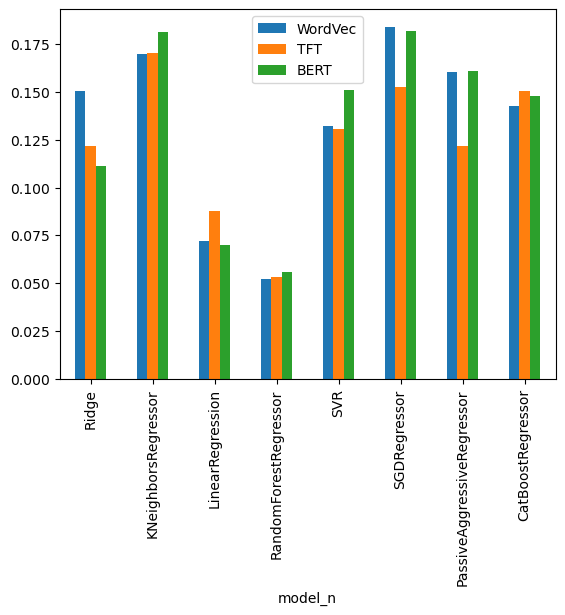

In [58]:
res_df=pd.DataFrame()
for n in [results_word, 
          results_tf,
          results_bert]:
    rw= pd.DataFrame(n,columns=['model_n',n[0][2],'vec'])
    rw=rw.drop('vec',axis=1)
    rw=rw.set_index(['model_n'])
    res_df[n[0][2]]=rw[n[0][2]]

display(res_df)
plt.figure(figsize=(16,14))
res_df.plot.bar()# plt.hist(res_df1,density=True)
plt.show()    

### Модель CNN

In [ ]:
max_length = vector_size
physical_devices = tf.config.list_physical_devices('GPU')

for X_train1,X_test1,mod in [[X_train_wtv_m,X_test_wtv_m,'WordVec'],
                          [X_train_tft_m,X_test_tft_m,'TFT'],
    
                          [X_train_bert_m,X_test_bert_m,'BERT']]:
    
    jit(target_backend='cuda') 
    njit(parallel=True)
    
    
    inp_shape = X_train1.shape[1]
    voc_size = X_train1.shape[0]

    model_cnn = Sequential([
        Embedding(input_dim=inp_shape,output_dim=max_length),
        Conv1D(256, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        Dense(100, activation='relu'),
        Dense(1, activation='sigmoid')])
    model_cnn.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mae'])    
    
    model_cnn.fit(X_train1, y_train, epochs=10, batch_size=64, validation_data=(X_test1, y_test))
    pred = model_cnn.predict(X_train1)
   # report = classification_report(y_test, np.round(pred))
    print(mod,mean_absolute_error(y_train,pred))
    res_df.loc['CNN',mod] = mean_absolute_error(y_train,pred)   


display (res_df)

Epoch 1/10
 6/16 ━━━━━━━━━━━━━━━━━━━━ 1:41 10s/step - loss: 0.2066 - mae: 0.2066

In [ ]:

display (res_df)   
plt.figure(figsize=(16,14))
res_df.plot.bar()# plt.hist(res_df1,density=True)
plt.show()    

## Выводы по выбору векторизации текста и выбору модели для тестирования

 - модель LinearRegression показала  результат по метрике
 - выбрана модель CNN и векторизация BERT

## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [ ]:
try :
    df4 = pd.read_csv('D:/YandexDisk/masterskay/сводный проект 5/to_upload/test_queries.csv' , sep ='|',index_col=[0])
    zipfile = 0                  
except:
    url = 'https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip'
    file_name = 'dsplus_integrated_project_4.zip'
    
    with urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
        
    # extracting required file from zipfile
        with zipfile.ZipFile(file_name) as zf:
            zf.extract('to_upload/test_queries.csv')

    df4 = pd.read_csv('to_upload/test_queries.csv', sep ='|',index_col=[0])
    zipfile = 1
    
display(df4.head())
df4.info()
df4.nunique()

In [ ]:
df4_clear = df4.copy()
df4_clear['disclaim'] = df4_clear['query_text'].apply(lambda x  : bool(re.search(chk_pat, x)))

#df4_clear = df4_clear[df4_clear['disclaim']==False].copy()
display(df4_clear)#[df4_clear['disclaim']==False])

In [ ]:
df4_clear.info()

In [ ]:
# векторизуем все изображения тест "D:\YandexDisk\masterskay\сводный проект 5\to_upload\test_images\191003283_992257f835.jpg"
path_test = 'to_upload/test_images/'
test_im_c = vec_img2(df4_clear['image'],path_test,zipfile)

len_c = test_im_c.shape[0]

In [ ]:
test_im_c

In [ ]:

def pad_att2 (tokenized):
    max_len = len(padded_train[1])
    padded = np.array([tokenized + [0]*(max_len - len(tokenized))])
    attention_mask = np.where(padded != 0, 1, 0)
    return (padded,attention_mask)    


def val_test(X):
    pad ,am = pad_att2(tokenizer.encode(X,truncation=True, padding=True,max_length=max_len,add_special_tokens=True,))
    x_t = bat_x(pad ,am)
    x_t = word_coo_add (x_t_c)
    returt (x_t)
    
def make_coo(xx):
    #len_c = test_im_c.shape[0]
    x_a = xx
    x_a = np.repeat(xx, repeats=len_c, axis=0)
    X_test_t = hstack((test_im_c, x_a))
    return (X_test_t)

def make_coo2 (xx):
    vc = vectorize(xx)
    x_a = coo_matrix(np.resize(vc,(len_c,len(vc))))
    
    X_test_t = hstack((test_im_c, x_a))
    return (X_test_t)
    
def ind_best (X_test_t):
    pred = model_cnn.predict(X_test_t)#.predict
    ind = pred.index(max(pred))
    return (ind)

def ind_best_rf (model_rf,X_test_t):
    
    pred = model_rf.predict(X_test_t) #,[1]*len_c)#.predict
    ind = np.unravel_index(np.argmax(pred), pred.shape)[0]
    return (ind)

def plot_b (text,nam_im):
    #nam_im = text_val.loc[ind,'image']
    img = Image.open(path_test+nam_im)
    fig = plt.figure(figsize=(10,10))
    #fig.add_subplot(2), 1)
    plt.imshow(img)
    
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks(text)#['query_text'])
    
    plt.tight_layout()
    plt.show()     
    return()

In [ ]:
    
text_val = df4_clear.sample(10)
text_val['lemm_text'] =  text_val['query_text'].apply(lambda x: lem_spa(x))
model_rf = RandomForestRegressor(warm_start=True,random_state=RANDOM_STATE).fit(X_train_wtv_m,y_train)
text_val = text_val.reset_index()

In [ ]:
for i in range (0,len(text_val) :
    display(text_val.loc[i])
    if text_val.loc[i,'disclaim']!=False : display('This image is unavailable in your country in compliance with local laws')
    else : X_test_t = make_coo2(text_val.loc[i,'lemm_text']}
        i_m = ind_best_rf(model_rf,X_test_t)
        plot_b(text_val.loc[i,'query_text'],df4_clear.loc[i_m,'image'])
        

In [ ]:
vc = vectorize(text_val.loc[0,'lemm_text'])

cm = coo_matrix(np.resize(vc,(len_c,len(vc))))

X_test_t = hstack((test_im_c, cm))

#model = RandomForestRegressor(warm_start=True,random_state=RANDOM_STATE).fit(X_train_wtv_m,y_train)
pred = model_rf.predict(X_test_t) #,[1]*len_c)#.predict

In [ ]:
#display(pred.index(pred.max()))
#ind = pred.index(max(pred))
peakIndexTuple = np.unravel_index(np.argmax(pred), pred.shape)
ind = peakIndexTuple[0]
display(df4_clear.loc[ind,'image'])
plot_b(text_val.loc[0,'query_text'],df4_clear.loc[ind,'image'])

r22 = tokenizer.encode(text_val.loc[182,'lemm_text'] ,truncation=True, #apply(lambda x: 
                     padding=True,
                     max_length=max_len,
                     add_special_tokens=True,)
display(r22)
display(len(r22))

#display(pad_att2(r22))
pad, am = pad_att2(r22)

sss33 = bat_x(pad, am)# model_bert(torch.LongTensor(pad), attention_mask=torch.LongTensor(am))
len_c = test_im_c.shape[0]
display(test_im_c.shape[0])
x_a = sss33
x_a = np.repeat(x_a, repeats=len_c, axis=0)

X_test_t = hstack((test_im_c, x_a))
display(X_test_t)
display(ind_best(X_test_t))

In [ ]:
text_val.info()
display(text_val)
#tokenizer.encode(text_val.loc[182,'lemm_text'] ,truncation=True,padding=True,max_length=max_len,add_special_tokens=True,)

text_val.info()
display(text_val)
text_val.loc[182,'lemm_text']


## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска